This code creates a buffer(50 meters max) around the spill points and finds the nearest flowline intersection, asserting that the operator name is the same. It then changes the matches spills geometry location to its respective flowline intersection point. 

- you cannot export 2 geometry columns, so we only kept the flowline geometry, not the spills

## Setup

In [61]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import nearest_points
from multiprocessing import Pool, cpu_count
from sklearn.neighbors import BallTree

import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')
pd.options.display.max_columns = None

In [62]:
# Load Data
flowlines_gdf = gpd.read_file('split_flowlines.geojson')
spills_gdf = gpd.read_file('spills.geojson')

In [63]:
spills_gdf

,trkg_num,Operator Name,facility_type,Spill_Desc,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,facility_status,Metallic?,incident_date,geometry
0,401530532,K P KAUFFMAN COMPANY INC,FLOWLINE,Historical contamination was discovered during...,1,Facility #7 consolidation line failed do to un...,The damaged section of flowline was repaired a...,Unknown,Unknown,-104.914183,40.019361,CL,Unknown,2018-01-10 00:00:00,POINT (507323.245 4429909.631)
1,401524345,GREAT WESTERN OPERATING COMPANY LLC,TANK BATTERY,Soil impacts were discovered during removal of...,1,Unknown,None,Unknown,Unknown,-104.467746,39.602613,AC,Unknown,2018-01-23 00:00:00,POINT (545695.434 4383787.964)
2,401540996,GRYNBERG* JACK DBA GRYNBERG PETROLEUM CO,FLOWLINE,Discovered vegetation kill while on location p...,1,Historic leak from flowline,Well is currently not flowing,Unknown,Unknown,-104.294000,40.724000,AC,Unknown,2018-02-07 00:00:00,POINT (559622.897 4508358.842)
3,401541267,PDC ENERGY INC,FLOWLINE,PDC discovered a reportable historical spill a...,1,"On January 8, 2018, historic petroleum hydroca...",The facility was decommissioned and will not b...,Unknown,Unknown,-104.674320,40.385970,CL,Unknown,2018-02-08 00:00:00,POINT (527642.817 4470648.45)
4,401569119,KERR MCGEE OIL & GAS ONSHORE LP,TANK BATTERY,While deconstructing the Weichel 26N-11HZ tank...,1,While deconstructing the Weichel 26N-11HZ tank...,The excavated portion of the Kerr-McGee tank b...,Unknown,Unknown,-104.631328,40.132392,CL,Unknown,2018-03-09 00:00:00,POINT (531408.908 4442516.738)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,404037117,VERDAD RESOURCES LLC,OIL AND GAS LOCATION,flowline between west well header and separato...,Recent,An underground wellhead flowline failed from a...,The section of pipe effected by corrosion was ...,Corrosion,Internal Corrosion,-104.704267,40.001795,CL,None,2024-12-19 00:00:00,POINT (525243.039 4427998.323)
1195,404037373,NOBLE ENERGY INC,OIL AND GAS LOCATION,A reportable release occurred on 12/19/24 at t...,Recent,"On 12/19/2024, produced water released from a ...",Noble conducts annual integrity tests on all s...,Corrosion,Corrosion Unknown,-104.519667,40.158056,CL,None,2024-12-19 00:00:00,POINT (540906.473 4445410.709)
1196,404038294,SIMCOE LLC,PRODUCED WATER TRANSFER SYSTEM,"On 12/20/24, a hunter notified a SIMCOE contra...",Recent,"As of January 8, 2025, SIMCOE has located and ...",SIMCOE intends to replace the fiberglass line ...,Unknown,None,-107.649574,37.214966,AC,None,2024-12-20 00:00:00,POINT (264893.954 4122008.812)
1197,404040195,CAERUS PICEANCE LLC,WELL SITE,Operator discovered an underground flowline le...,Recent,Buried flow line was compromised due to intern...,"Point of release was exposed, verified, and re...",Corrosion,Corrosion Unknown,-108.110408,39.578405,CL,None,2024-12-25 00:00:00,POINT (232845.958 4385588.665)


In [64]:
# Check if CRS is the same for both files
if flowlines_gdf.crs != spills_gdf.crs:
    flowlines_gdf = flowlines_gdf.to_crs(spills_gdf.crs)

In [65]:
print(spills_gdf.crs)
print(flowlines_gdf.crs)

EPSG:26913
EPSG:26913


In [66]:
# Check size
print(flowlines_gdf.shape)
print(spills_gdf.shape)

(26361, 28)
(1199, 15)


In [67]:
# Check and count missing geometries in spills
missing_geometry_count = spills_gdf[spills_gdf.geometry.isna()].shape[0]

# Print the count of missing geometries
print(f"Number of spills with missing geometry: {missing_geometry_count}")

Number of spills with missing geometry: 180


In [68]:
# Drop rows with missing geometries
spills_gdf = spills_gdf.dropna(subset=['geometry'])
spills_gdf.reset_index(drop=True, inplace=True)

In [69]:
# Check size
print(flowlines_gdf.shape)
print(spills_gdf.shape)

(26361, 28)
(1019, 15)


## Matching

In [70]:
# Split the spills_gdf into two halves
spills_gdf_1 = spills_gdf.iloc[:len(spills_gdf) // 2].copy()  # First half of the spills_gdf
spills_gdf_2 = spills_gdf.iloc[len(spills_gdf) // 2:].copy()  # Second half of the spills_gdf

In [71]:
# Global counters
same_operator_match_count = 0
no_match_count = 0

# BallTree builder
def create_balltree(flowlines_gdf):
    coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in flowlines_gdf.geometry])
    return BallTree(coords, leaf_size=15), coords

ball_tree, flowline_coords = create_balltree(flowlines_gdf)

# Nearest flowline finder (with intersection point and distance)
def find_nearest_matching_flowline(row, flowlines_gdf, ball_tree, flowline_coords, spill_index):
    global same_operator_match_count, no_match_count
    spill_point = row.geometry
    spill_operator = row['Operator Name']

    if pd.isnull(spill_operator):
        no_match_count += 1
        print(f"No operator match found for Spill index {spill_index} (Operator Name is missing)")
        return None, None, None

    spill_operator = spill_operator.strip().lower()
    spill_coords = np.array([[spill_point.x, spill_point.y]])
    dist, indices = ball_tree.query(spill_coords, k=len(flowlines_gdf))
    sorted_flowlines = flowlines_gdf.iloc[indices[0]].copy()
    sorted_flowlines['distance'] = dist[0]

    for _, flowline in sorted_flowlines.iterrows():
        flowline_operator = flowline['Operator'].strip().lower()
        if spill_operator == flowline_operator:
            same_operator_match_count += 1
            nearest_point = flowline.geometry.interpolate(flowline.geometry.project(spill_point))
            distance = spill_point.distance(nearest_point)
            print(f"Match #{same_operator_match_count}: Spill index {spill_index} matched with flowline index {flowline.name}.")
            print(f"    → Nearest point on flowline: {nearest_point}")
            print(f"    → Distance from original point: {distance:.2f} meters")
            return flowline.name, nearest_point, distance

    no_match_count += 1
    print(f"No operator match found for Spill index {spill_index}")
    return None, None, None

# Spill processor
def process_spills_gdf(spills_gdf, flowlines_gdf, ball_tree, flowline_coords):
    matched_indices = []
    new_geoms = []
    distances = []

    for idx, row in spills_gdf.iterrows():
        match_idx, new_geom, dist = find_nearest_matching_flowline(row, flowlines_gdf, ball_tree, flowline_coords, idx)
        matched_indices.append(match_idx)
        new_geoms.append(new_geom)
        distances.append(dist)

    spills_gdf['nearest_flowline_index'] = matched_indices
    spills_gdf['matched_geometry'] = new_geoms
    spills_gdf['distance_m'] = distances

    matched_spills_gdf = spills_gdf[spills_gdf['nearest_flowline_index'].notnull()].copy()
    matched_spills_gdf['nearest_flowline_index'] = matched_spills_gdf['nearest_flowline_index'].astype(int)

    merged_gdf = matched_spills_gdf.merge(
        flowlines_gdf, left_on='nearest_flowline_index', right_index=True, suffixes=('', '_flowline')
    )

    return matched_spills_gdf, merged_gdf

# Process both halves
matched_spills_1, merged_gdf_1 = process_spills_gdf(spills_gdf_1, flowlines_gdf, ball_tree, flowline_coords)
matched_spills_2, merged_gdf_2 = process_spills_gdf(spills_gdf_2, flowlines_gdf, ball_tree, flowline_coords)

No operator match found for Spill index 0
Match #1: Spill index 1 matched with flowline index 9766.
    → Nearest point on flowline: POINT (545287.4998000003 4410654.506399999)
    → Distance from original point: 26869.64 meters
No operator match found for Spill index 2
Match #2: Spill index 3 matched with flowline index 10253.
    → Nearest point on flowline: POINT (529087.4055000008 4468617.8136)
    → Distance from original point: 2492.05 meters
Match #3: Spill index 4 matched with flowline index 25968.
    → Nearest point on flowline: POINT (526647.8728000002 4445498.033999999)
    → Distance from original point: 5617.44 meters
Match #4: Spill index 5 matched with flowline index 25956.
    → Nearest point on flowline: POINT (534932.6464999996 4463662.370799999)
    → Distance from original point: 1215.41 meters
Match #5: Spill index 6 matched with flowline index 18544.
    → Nearest point on flowline: POINT (521636.926 4482833.1612)
    → Distance from original point: 1508.79 meter

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/ecmc_env/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Match #428: Spill index 500 matched with flowline index 18079.
    → Nearest point on flowline: POINT (553230.5586000006 4532598.5306)
    → Distance from original point: 4684.84 meters
Match #429: Spill index 501 matched with flowline index 24715.
    → Nearest point on flowline: POINT (510826.7988999993 4432104.836200001)
    → Distance from original point: 5431.17 meters
Match #430: Spill index 502 matched with flowline index 11360.
    → Nearest point on flowline: POINT (526827.7119000006 4476417.5024)
    → Distance from original point: 130.00 meters
Match #431: Spill index 503 matched with flowline index 11062.
    → Nearest point on flowline: POINT (245477.11610000007 4370989.472400001)
    → Distance from original point: 23871.67 meters
Match #432: Spill index 504 matched with flowline index 12094.
    → Nearest point on flowline: POINT (499096.8397000002 4441339.9515)
    → Distance from original point: 201.16 meters
Match #433: Spill index 505 matched with flowline index 1107

In [72]:
# Combine updated spills with matched points
updated_spills_gdf = pd.concat([matched_spills_1, matched_spills_2], ignore_index=True)
updated_spills_gdf.to_file("updated_spills.geojson", driver="GeoJSON")

# Prepare flowline-risk dataset
merged_gdf_1 = merged_gdf_1.drop(columns=['geometry'])
merged_gdf_2 = merged_gdf_2.drop(columns=['geometry'])
merged_spills_flowlines = pd.concat([merged_gdf_1, merged_gdf_2], ignore_index=True)
merged_spills_flowlines = merged_spills_flowlines.rename(columns={'geometry_flowline': 'geometry'})
merged_spills_flowlines = gpd.GeoDataFrame(merged_spills_flowlines, geometry='geometry', crs=flowlines_gdf.crs)

# Identify unmatched flowlines
matched_flowline_indices = merged_spills_flowlines['nearest_flowline_index'].unique()
filtered_flowlines_gdf = flowlines_gdf[~flowlines_gdf.index.isin(matched_flowline_indices)].copy()

print(list(filtered_flowlines_gdf.columns))
print(list(merged_spills_flowlines.columns))

# Add risk column
filtered_flowlines_gdf['risk'] = 0
merged_spills_flowlines['risk'] = 1

# Combine all flowlines
combined_gdf = pd.concat([merged_spills_flowlines, filtered_flowlines_gdf], ignore_index=True)
combined_gdf.to_file("combined_gdf.geojson", driver="GeoJSON")

['ACTIONDESCRIPTION', 'BEDDINGMATERIAL', 'COMPANY_NAME', 'CONSTRUCTDATE', 'Diam_in', 'ENDLAT', 'ENDLONG', 'ENTIRELINEREMOVED', 'FLOWLINEACTION', 'FLOWLINEID', 'Fluid', 'LOCATIONTYPE', 'LOCATION_ID', 'Length_ft', 'MAXOPPRESSURE', 'Material', 'OPERATOR_NUM', 'Operator', 'PIPEMATERIAL', 'RECEIVE_DATE', 'SHAPE_Length', 'STARTLAT', 'STARTLOCATIONID', 'STARTLONG', 'Status', 'TYPEOFFLUIDTRANS', 'unique_id', 'geometry']
['trkg_num', 'Operator Name', 'facility_type', 'Spill_Desc', 'Spill Type', 'Root Cause', 'Preventative Measure', 'Root Cause Type', 'Detailed Root Cause Type', 'Long', 'Lat', 'facility_status', 'Metallic?', 'incident_date', 'nearest_flowline_index', 'matched_geometry', 'distance_m', 'ACTIONDESCRIPTION', 'BEDDINGMATERIAL', 'COMPANY_NAME', 'CONSTRUCTDATE', 'Diam_in', 'ENDLAT', 'ENDLONG', 'ENTIRELINEREMOVED', 'FLOWLINEACTION', 'FLOWLINEID', 'Fluid', 'LOCATIONTYPE', 'LOCATION_ID', 'Length_ft', 'MAXOPPRESSURE', 'Material', 'OPERATOR_NUM', 'Operator', 'PIPEMATERIAL', 'RECEIVE_DATE', 

In [73]:
# Check consistency
risk_1_count = combined_gdf['risk'].sum()
print(f"\n✅ Total matched spills = 1: {risk_1_count}")

# Final unmatched count
print(f"\n🚫 Total unmatched spills: {no_match_count}")


✅ Total matched spills = 1: 829

🚫 Total unmatched spills: 190


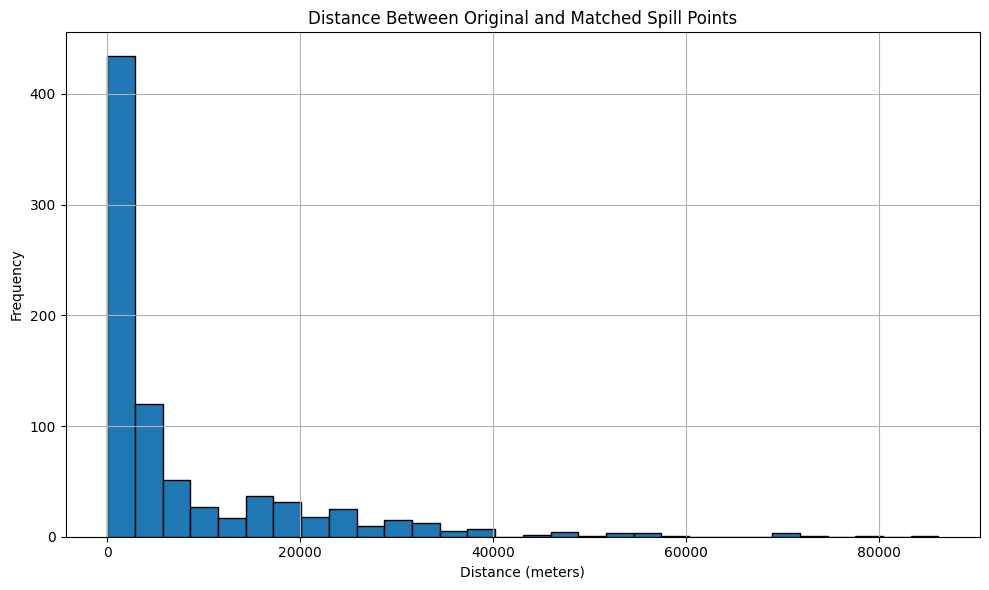

In [74]:
# range of distances
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(updated_spills_gdf['distance_m'].dropna(), bins=30, edgecolor='black')
plt.title('Distance Between Original and Matched Spill Points')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

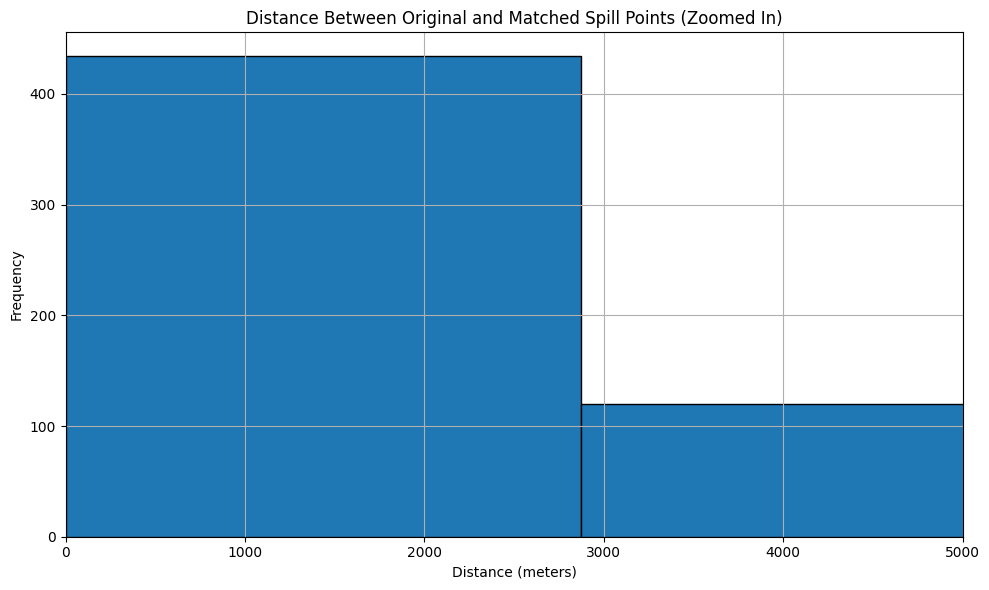

In [75]:
# Plot histogram and zoom in
plt.figure(figsize=(10, 6))
plt.hist(updated_spills_gdf['distance_m'].dropna(), bins=30, edgecolor='black')
plt.title('Distance Between Original and Matched Spill Points (Zoomed In)')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # Zoom in on shorter distances
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
print(combined_gdf.shape)

(26789, 46)


In [77]:
combined_gdf.head()

,trkg_num,Operator Name,facility_type,Spill_Desc,Spill Type,Root Cause,Preventative Measure,Root Cause Type,Detailed Root Cause Type,Long,Lat,facility_status,Metallic?,incident_date,nearest_flowline_index,matched_geometry,distance_m,ACTIONDESCRIPTION,BEDDINGMATERIAL,COMPANY_NAME,CONSTRUCTDATE,Diam_in,ENDLAT,ENDLONG,ENTIRELINEREMOVED,FLOWLINEACTION,FLOWLINEID,Fluid,LOCATIONTYPE,LOCATION_ID,Length_ft,MAXOPPRESSURE,Material,OPERATOR_NUM,Operator,PIPEMATERIAL,RECEIVE_DATE,SHAPE_Length,STARTLAT,STARTLOCATIONID,STARTLONG,Status,TYPEOFFLUIDTRANS,unique_id,geometry,risk
0,401524345.0,GREAT WESTERN OPERATING COMPANY LLC,TANK BATTERY,Soil impacts were discovered during removal of...,1,Unknown,None,Unknown,Unknown,-104.467746,39.602613,AC,Unknown,2018-01-23 00:00:00,9766.0,POINT (545287.4998000003 4410654.506399999),26869.639020,None,None,GREAT WESTERN OPERATING COMPANY LLC ...,1972-08-07,2.0,39.844718,-104.470638,None,None,470450.0,Oil,Production Facilities,470449.0,542.71,NaN,Steel,10110,GREAT WESTERN OPERATING COMPANY LLC,None,2020-11-11 14:17:26.367,165.354619,39.845233,319720.0,-104.472460,Active,None,flowline_5162,"LINESTRING (545287.5 4410654.506, 545132.965 4...",1
1,401541267.0,PDC ENERGY INC,FLOWLINE,PDC discovered a reportable historical spill a...,1,"On January 8, 2018, historic petroleum hydroca...",The facility was decommissioned and will not b...,Unknown,Unknown,-104.674320,40.385970,CL,Unknown,2018-02-08 00:00:00,10253.0,POINT (529087.4055000008 4468617.8136),2492.050938,None,None,PDC ENERGY INC ...,2018-01-04,3.5,40.367408,-104.656320,None,Registration,477981.0,Produced Fluids,Production Facilities,447490.0,404.27,NaN,Carbon Steel,69175,PDC ENERGY INC,Carbon Steel,2019-10-18 14:51:46.423,123.175010,40.367640,447490.0,-104.657390,New Construction,Crude Oil,flowline_5631,"LINESTRING (529087.406 4468617.814, 529165.786...",1
2,401569119.0,KERR MCGEE OIL & GAS ONSHORE LP,TANK BATTERY,While deconstructing the Weichel 26N-11HZ tank...,1,While deconstructing the Weichel 26N-11HZ tank...,The excavated portion of the Kerr-McGee tank b...,Unknown,Unknown,-104.631328,40.132392,CL,Unknown,2018-03-09 00:00:00,25968.0,POINT (526647.8728000002 4445498.033999999),5617.435796,The Nichols 31-8 P&A is complete. The well hea...,None,KERR MCGEE OIL & GAS ONSHORE LP ...,2011-08-10,2.0,40.159243,-104.687167,True,Abandonment,457300.0,PRODUCED WATER,Production Facilities,318070.0,18.23,NaN,Steel,47120,KERR MCGEE OIL & GAS ONSHORE LP,None,2018-09-21 12:32:54.807,5.553076,40.158592,332301.0,-104.690146,ACTIVE,None,flowline_14531,"LINESTRING (526647.996 4445503.586, 526647.873...",1
3,401576719.0,NOBLE ENERGY INC,TANK BATTERY,During decommisioning of facilitiy soil impact...,1,Historical impacts were discovered during dism...,The site was dismantled and reclamation has oc...,Unknown,Unknown,-104.602541,40.319666,CL,Unknown,2018-03-15 00:00:00,25956.0,POINT (534932.6464999996 4463662.370799999),1215.414921,None,None,NOBLE ENERGY INC ...,2004-05-10,2.0,40.319950,-104.587080,None,Registration,457931.0,Multiphase,Production Facilities,422528.0,1135.36,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2018-05-23 15:18:16.953,345.926043,40.322777,331808.0,-104.588813,Active,None,flowline_14519,"LINESTRING (534932.646 4463662.371, 535082.761...",1
4,401585074.0,NOBLE ENERGY INC,TANK BATTERY,During reclamation activities historical impac...,1,During reclamation of the oil and gas facility...,The location was plugged and abandoned and exc...,Unknown,Unknown,-104.754486,40.484583,CL,Unknown,2018-03-22 00:00:00,18544.0,POINT (521636.926 4482833.1612),1508.792195,None,None,NOBLE ENERGY INC ...,1993-11-07,2.0,40.495920,-104.744664,None,Registration,466186.0,Multiphase,Production Facilities,455178.0,768.11,NaN,Carbon Steel,100322,NOBLE ENERGY INC,None,2019-07-19 09:01:04.960,234.027984,40.497521,310147.0,-104.746461,Abandoned,None,flowline_11319,"LINESTRING (521484.139 4483010.433, 521636.926...",1


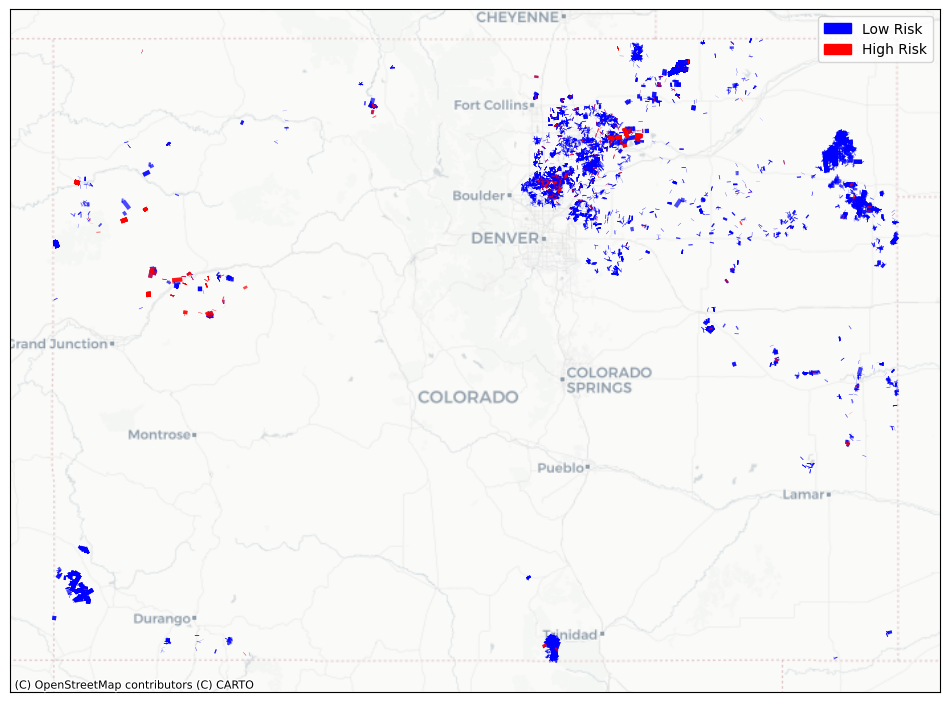

In [78]:
# Convert CRS to EPSG:3857 for contextily base map
combined_gdf_wm = combined_gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
combined_gdf_wm = combined_gdf_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
combined_gdf_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

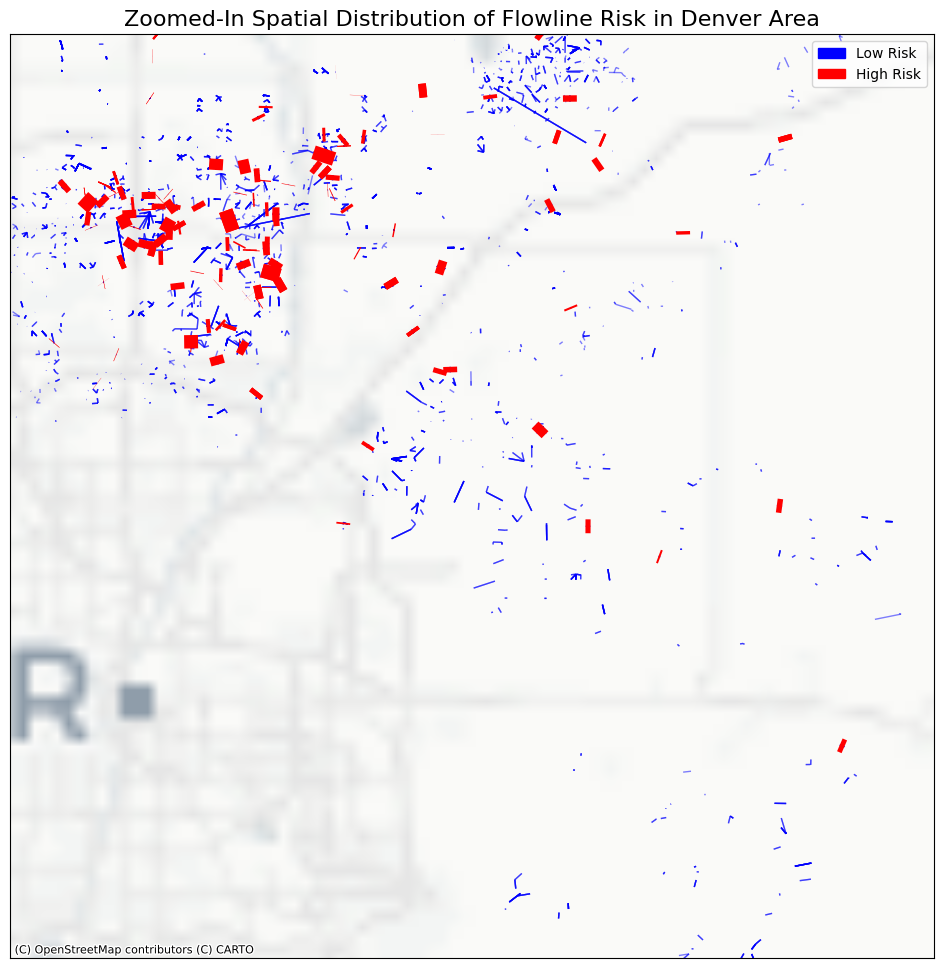

In [79]:
# Separate the data by risk level
low_risk = combined_gdf_wm[combined_gdf_wm['risk'] == 0]
high_risk = combined_gdf_wm[combined_gdf_wm['risk'] == 1]

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size

# Plot low-risk geometries (blue) first
low_risk.plot(ax=ax, color='blue', alpha=0.5, linewidth=1)

# Plot high-risk geometries (red) on top with a much larger size
high_risk.plot(ax=ax, color='red', alpha=1.0, linewidth=10)  # Significantly increased line width

# Add a lighter, minimalistic base map to reduce visual clutter
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# Set the plot limits to zoom into the desired area
ax.set_xlim([-11700000, -11600000])
ax.set_ylim([4800000, 4900000])

# Clean up axis
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

# Optional: Add title
ax.set_title('Zoomed-In Spatial Distribution of Flowline Risk in Denver Area', fontsize=16)

# Display the plot
plt.show()